### 1. Importing Necessary Libraries
In this initial section, we import all the required libraries for data manipulation, visualization, and testing. Libraries such as `pandas` and `numpy` are essential for handling data structures and numerical operations, while `json` aids in parsing JSON files. For visualization, we utilize `matplotlib.pyplot`, and for date manipulations, we import `datetime` and `timedelta`. Additionally, `unittest` is used to create and run test cases ensuring the reliability of our data processing functions.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.testing import assert_frame_equal
import unittest

### 2. Loading the Data
Here, we define the file paths for our orders and invoices datasets. The `load_orders` function reads the orders data from a CSV file using a semicolon delimiter, ensuring that the data is correctly parsed into a pandas DataFrame. Similarly, the `load_invoices` function loads the invoices data from a JSON file, extracting the relevant invoice information and converting it into a DataFrame. Loading data into structured formats is crucial for efficient processing and analysis in subsequent steps.

In [2]:
orders_path = '../resources/orders.csv'
invoices_path = '../resources/invoicing_data.json'

def load_orders(orders_path):
    """
    Load orders data from a CSV file.

    Parameters:
    orders_path (str): The file path to the orders CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the orders data.
    """
    orders_df = pd.read_csv(orders_path, delimiter=";")
    return orders_df
    
def load_invoices(invoices_path):
    """
    Load invoices data from a JSON file.

    Parameters:
    invoices_path (str): The file path to the invoices JSON file.

    Returns:
    pd.DataFrame: A DataFrame containing the invoices data.
    """
    with open(invoices_path) as f:
        invoices_data = json.load(f)['data']['invoices']
    invoices_df = pd.DataFrame(invoices_data)

    return invoices_df

orders_df = load_orders(orders_path)
invoices_df = load_invoices(invoices_path)

### 3. Data Cleaning and Staging Functions for Orders Data
Before performing any calculations, it's essential to ensure that the data is clean and well-structured. This section introduces several functions designed to clean and standardize the data:

- `format_date`: Converts date strings into datetime objects, handling potential errors gracefully.
- `clean_company_names`: Standardizes company names by converting them to lowercase, removing punctuation, common suffixes (like 'Ltd', 'Inc'), and extra spaces.
- `consolidate_company_ids`: Ensures consistency in company IDs by assigning the earliest valid ID to all records of the same company.
- `clean_json_column` & `create_columns_from_json`: Handle and parse JSON-like data in columns, extracting specific fields and filling in default values where necessary.
- `create_additional_columns`: Creates new columns such as full_contact_name and contact_address by concatenating existing fields.
- `stage_orders_data`: Orchestrates the cleaning process by sequentially applying the above functions to the raw orders DataFrame, resulting in a clean and staged DataFrame ready for analysis.
These functions collectively form a staging flow, ensuring that the orders data is ready for modeling.

In [3]:
"""
Note: With a bit more time, I could build a robust format date function 
that covers most edgecases, and date format does not need to be specified.
"""

def format_date(df, column_name, date_format):
    """
    Convert a date column in a DataFrame to datetime format.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the date column.
    column_name (str): The name of the date column to convert.
    date_format (str): The format of the date strings in the column.

    Returns:
    pd.DataFrame: The DataFrame with the date column converted to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name], format=date_format, errors='coerce')
    return df

def clean_company_names(df, column_name):
    """
    Standardize company names by converting to lowercase, removing punctuation and common suffixes, and trimming spaces.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the company names.
    column_name (str): The name of the column containing company names to clean.

    Returns:
    pd.DataFrame: The DataFrame with cleaned company names.
    """
    df[f'{column_name}'] = (df[column_name]
                        .str.lower()  # Convert to lowercase
                        .str.replace(r'\.', '', regex=True)  # Remove common suffixes
                        .str.replace(r'ltd|co|inc|gmbh', '', regex=True)  # Remove common suffixes
                        .str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove special characters
                        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
                        .str.strip()  # Remove leading and trailing spaces
                        .str.title()
                      )
    return df
    
def consolidate_company_ids(df, company_id_column, primary_key_column, date_column):
    """
    Standardize company IDs using the earliest date per company.
    If a company has both None and valid company IDs, the valid company ID is used to fill the None.
    If all company IDs for a company are None, they remain None.

    Parameters:
    df (pd.DataFrame): The DataFrame containing company data.
    company_id_column (str): The name of the column containing company IDs.
    primary_key_column (str): The column to group by (e.g., cleaned company name).
    date_column (str): The date column to determine the earliest date.

    Returns:
    pd.DataFrame: The DataFrame with consolidated company IDs.
    """
    company_id_mapping = {}

    grouped = df.groupby(primary_key_column)

    for company_name, group in grouped:
        valid_ids = group.dropna(subset=[company_id_column])

        if not valid_ids.empty:
            earliest_valid_idx = valid_ids[date_column].idxmin()
            company_id = df.loc[earliest_valid_idx, company_id_column]
            df.loc[df[primary_key_column] == company_name, company_id_column] = company_id
        else:
            pass

    return df


def clean_json_column(column_data, default_values):
    """
    Clean and parse a column containing JSON-like data.

    Parameters:
    column_data (str or dict): The data from the JSON-like column.
    default_values (dict): A dictionary of default values to use if parsing fails.

    Returns:
    dict: A dictionary containing the parsed data or default values.
    """
    if isinstance(column_data, dict):
        return column_data
    if pd.isna(column_data):
        return default_values
    try:
        column_data = column_data.strip('[]')
        data_dict = json.loads(column_data.replace("'", '"'))
        return {key: data_dict.get(key, default_values[key]) for key in default_values}
    except json.JSONDecodeError:
        return default_values

def create_columns_from_json(df, column_name, new_column_names, default_values):
    """
    Create separate columns from a JSON-like column and drop the original column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the JSON-like column.
    column_name (str): The name of the column containing JSON-like data.
    new_column_names (list): List of new column names to create.
    default_values (dict): Default values to use if parsing fails.

    Returns:
    pd.DataFrame: The DataFrame with new columns added.
    """
    df[f'{column_name}'] = df[column_name].apply(lambda x: clean_json_column(x, default_values))
    for new_column in new_column_names:
        df[new_column] = df[f'{column_name}'].apply(lambda x: x[new_column])
    return df

# Create additional columns like full contact name
def create_additional_columns(df):
    """
    Create additional columns like 'full_contact_name' and 'contact_address' by concatenating existing columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing contact data.

    Returns:
    pd.DataFrame: The DataFrame with additional columns added.
    """
    df['full_contact_name'] = df['contact_name'] + ' ' + df['contact_surname']
    df['contact_address'] = df['city'] + ', ' + df['postal_code'].astype(str)
    return df


def stage_orders_data(df):
    """
    Perform data cleaning and preparation on the orders DataFrame.

    Parameters:
    df (pd.DataFrame): The raw orders DataFrame.

    Returns:
    pd.DataFrame: The cleaned and staged orders DataFrame.
    """
    df = format_date(df, 'date', '%d.%m.%y')    
    df = clean_company_names(df, 'company_name')
    df = consolidate_company_ids(df, 'company_id', 'company_name', 'date')
    df = create_columns_from_json(df, 'contact_data', ['contact_name', 'contact_surname', 'city', 'cp'], contact_default_values)
    df = df.rename(columns={'cp': 'postal_code'})
    df = create_additional_columns(df)
    df = df.sort_values(by='date', ascending=True)
    df = df.drop(['contact_data'], axis=1)
    df = df.drop_duplicates()
    return df

# Default values for contact_data
contact_default_values = {
    "contact_name": "John",
    "contact_surname": "Doe",
    "city": "Unknown",
    "cp": "UNK00"
    }

### 4. Testing the Staging Process
To guarantee the reliability of our data cleaning pipeline, we implement a suite of unit tests using Python's unittest framework. The `TestStageOrdersData` class contains multiple test cases that validate the correctness of the staging process under various scenarios, including handling missing data, partial contact information, inconsistent company names, and incorrect JSON formats. These tests help identify and rectify potential issues early in the development process, ensuring that our staging functions perform as expected.

In [4]:
class TestStageOrdersData(unittest.TestCase):

    def test_complete_staging_process(self):
        """Test the complete staging process on a sample orders DataFrame."""
        # Input DataFrame (raw orders data)
        input_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme Inc.', 'Globex Co'],
            'date': ['01.01.21', '15.02.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]',
                '[{ "contact_name": "Jane", "contact_surname": "Smith", "city": "Gotham", "cp": "54321" }]'
            ],
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme', 'Globex'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-15']),
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob'],
            'contact_name': ['John', 'Jane'],
            'contact_surname': ['Doe', 'Smith'],
            'city': ['Metropolis', 'Gotham'],
            'postal_code': ['12345', '54321'],
            'full_contact_name': ['John Doe', 'Jane Smith'],
            'contact_address': ['Metropolis, 12345', 'Gotham, 54321']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[['order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
                                   'contact_name', 'contact_surname', 'city', 'postal_code',
                                   'full_contact_name', 'contact_address']]
        expected_df = expected_df.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)

    def test_staging_with_missing_contact_data(self):
        """Test staging process with missing contact_data."""
        # Input DataFrame with missing contact_data
        input_data = {
            'order_id': [1],
            'company_id': [10],
            'company_name': ['Acme Inc.'],
            'date': ['01.01.21'],
            'contact_data': [None],
            'crate_type': ['Type A'],
            'salesowners': ['Alice']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1],
            'company_id': [10],
            'company_name': ['Acme'],
            'date': pd.to_datetime(['2021-01-01']),
            'crate_type': ['Type A'],
            'salesowners': ['Alice'],
            'contact_name': ['John'],
            'contact_surname': ['Doe'],
            'city': ['Unknown'],
            'postal_code': ['UNK00'],
            'full_contact_name': ['John Doe'],
            'contact_address': ['Unknown, UNK00']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[['order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
                                   'contact_name', 'contact_surname', 'city', 'postal_code',
                                   'full_contact_name', 'contact_address']]
        expected_df = expected_df.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)
        
    def test_staging_with_partial_contact_data(self):
        """Test staging process with partial contact_data; missing fields should be filled with default values."""
        # Input DataFrame with partial contact_data
        input_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme Inc.', 'Globex Co'],
            'date': ['01.01.21', '15.02.21'],
            'contact_data': [
                '[{ "contact_name": "John", "city": "Metropolis" }]',
                '[{ "contact_surname": "Smith", "cp": "54321" }]'
            ],
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme', 'Globex'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-15']),
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob'],
            'contact_name': ['John', 'John'],
            'contact_surname': ['Doe', 'Smith'],
            'city': ['Metropolis', 'Unknown'],
            'postal_code': ['UNK00', '54321'],
            'full_contact_name': ['John Doe', 'John Smith'],
            'contact_address': ['Metropolis, UNK00', 'Unknown, 54321']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[[
            'order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
            'contact_name', 'contact_surname', 'city', 'postal_code',
            'full_contact_name', 'contact_address'
        ]]
        expected_df = expected_df.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)
        
    def test_staging_with_inconsistent_company_names(self):
        """Test staging process with inconsistent company names."""
        # Input DataFrame with inconsistent company names
        input_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme Inc.', 'ACME INC'],
            'date': ['01.01.21', '31.12.20'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]',
                '[{ "contact_name": "Jane", "contact_surname": "Smith", "city": "Gotham", "cp": "54321" }]'],
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [2, 1],
            'company_id': [20, 20],
            'company_name': ['Acme', 'Acme'],
            'date': pd.to_datetime(['2020-12-31', '2021-01-01']),
            'crate_type': ['Type B', 'Type A'],
            'salesowners': ['Bob', 'Alice'],
            'contact_name': ['Jane', 'John'],
            'contact_surname': ['Smith', 'Doe'],
            'city': ['Gotham', 'Metropolis'],
            'postal_code': ['54321', '12345'],
            'full_contact_name': ['Jane Smith', 'John Doe'],
            'contact_address': ['Gotham, 54321', 'Metropolis, 12345']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[['order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
                                   'contact_name', 'contact_surname', 'city', 'postal_code',
                                   'full_contact_name', 'contact_address']]
        expected_df = expected_df.reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)
    def test_full_contact_name_construction(self):
        """Test that full_contact_name is correctly constructed from contact_name and contact_surname."""
        # Input DataFrame with various combinations of contact_name and contact_surname
        input_data = {
            'order_id': [1, 2, 3, 4],
            'company_id': [10, 20, 30, 40],
            'company_name': ['Acme Inc.', 'Globex Co', 'Soylent Ltd', 'Initech GmbH'],
            'date': ['01.01.21', '15.02.21', '10.03.21', '20.04.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]',
                '[{ "contact_name": "Jane", "city": "Gotham", "cp": "54321" }]',
                '[{ "contact_surname": "Smith", "city": "Springfield", "cp": "67890" }]',
                '[{ "city": "Shelbyville", "cp": "98765" }]'
            ],
            'crate_type': ['Type A', 'Type B', 'Type C', 'Type D'],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Dana']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1, 2, 3, 4],
            'company_id': [10, 20, 30, 40],
            'company_name': ['Acme', 'Globex', 'Soylent', 'Initech'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-15', '2021-03-10', '2021-04-20']),
            'crate_type': ['Type A', 'Type B', 'Type C', 'Type D'],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Dana'],
            'contact_name': ['John', 'Jane', 'John', 'John'],
            'contact_surname': ['Doe', 'Doe', 'Smith', 'Doe'],
            'city': ['Metropolis', 'Gotham', 'Springfield', 'Shelbyville'],
            'postal_code': ['12345', '54321', '67890', '98765'],
            'full_contact_name': ['John Doe', 'Jane Doe', 'John Smith', 'John Doe'],
            'contact_address': ['Metropolis, 12345', 'Gotham, 54321', 'Springfield, 67890', 'Shelbyville, 98765']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[[
            'order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
            'contact_name', 'contact_surname', 'city', 'postal_code',
            'full_contact_name', 'contact_address'
        ]]
        expected_df = expected_df.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)

    def test_contact_address_formatting(self):
        """Test that contact_address is correctly formatted from city and postal_code."""
        # Input DataFrame with various combinations of city and postal_code
        input_data = {
            'order_id': [1, 2, 3, 4],
            'company_id': [10, 20, 30, 40],
            'company_name': ['Acme Inc.', 'Globex Co', 'Soylent Ltd', 'Initech GmbH'],
            'date': ['01.01.21', '15.02.21', '10.03.21', '20.04.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]',
                '[{ "contact_name": "Jane", "contact_surname": "Smith", "cp": "54321" }]',
                '[{ "contact_name": "Bob", "contact_surname": "Brown", "city": "Springfield" }]',
                '[{ "contact_name": "Alice", "contact_surname": "Johnson" }]'
            ],
            'crate_type': ['Type A', 'Type B', 'Type C', 'Type D'],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Dana']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1, 2, 3, 4],
            'company_id': [10, 20, 30, 40],
            'company_name': ['Acme', 'Globex', 'Soylent', 'Initech'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-15', '2021-03-10', '2021-04-20']),
            'crate_type': ['Type A', 'Type B', 'Type C', 'Type D'],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Dana'],
            'contact_name': ['John', 'Jane', 'Bob', 'Alice'],
            'contact_surname': ['Doe', 'Smith', 'Brown', 'Johnson'],
            'city': ['Metropolis', 'Unknown', 'Springfield', 'Unknown'],
            'postal_code': ['12345', '54321', 'UNK00', 'UNK00'],
            'full_contact_name': ['John Doe', 'Jane Smith', 'Bob Brown', 'Alice Johnson'],
            'contact_address': ['Metropolis, 12345', 'Unknown, 54321', 'Springfield, UNK00', 'Unknown, UNK00']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[[
            'order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
            'contact_name', 'contact_surname', 'city', 'postal_code',
            'full_contact_name', 'contact_address'
        ]]
        expected_df = expected_df.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)
        
    def test_staging_with_missing_company_id(self):
        """Test staging process when company_id is missing."""
        # Input DataFrame with missing company_id
        input_data = {
            'order_id': [1],
            'company_id': [None],
            'company_name': ['Acme Inc.'],
            'date': ['01.01.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]'],
            'crate_type': ['Type A'],
            'salesowners': ['Alice']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1],
            'company_id': [None],
            'company_name': ['Acme'],
            'date': pd.to_datetime(['2021-01-01']),
            'crate_type': ['Type A'],
            'salesowners': ['Alice'],
            'contact_name': ['John'],
            'contact_surname': ['Doe'],
            'city': ['Metropolis'],
            'postal_code': ['12345'],
            'full_contact_name': ['John Doe'],
            'contact_address': ['Metropolis, 12345']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[['order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
                                   'contact_name', 'contact_surname', 'city', 'postal_code',
                                   'full_contact_name', 'contact_address']]
        expected_df = expected_df.reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df, check_dtype=False)

    def test_staging_with_additional_columns(self):
        """Test staging process with additional unexpected columns."""
        # Input DataFrame with extra columns
        input_data = {
            'order_id': [1],
            'company_id': [10],
            'company_name': ['Acme Inc.'],
            'date': ['01.01.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]'],
            'crate_type': ['Type A'],
            'salesowners': ['Alice'],
            'extra_column': ['Extra Value']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1],
            'company_id': [10],
            'company_name': ['Acme'],
            'date': pd.to_datetime(['2021-01-01']),
            'crate_type': ['Type A'],
            'salesowners': ['Alice'],
            'extra_column': ['Extra Value'],
            'contact_name': ['John'],
            'contact_surname': ['Doe'],
            'city': ['Metropolis'],
            'postal_code': ['12345'],
            'full_contact_name': ['John Doe'],
            'contact_address': ['Metropolis, 12345']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[['order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
                                   'extra_column', 'contact_name', 'contact_surname', 'city', 'postal_code',
                                   'full_contact_name', 'contact_address']]
        expected_df = expected_df.reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)

    def test_company_id_consolidation(self):
        """Test that company IDs are correctly consolidated based on earliest date after cleaning company names."""
        # Input DataFrame with duplicate company names but different company IDs
        input_data = {
            'order_id': [1, 2, 3],
            'company_id': [100, 200, 300],
            'company_name': ['Acme Inc.', 'ACME INC', 'Acme ltd.'],
            'date': ['15.03.21', '10.02.21', '01.01.21'],
            'contact_data': [
                '[{ "contact_name": "John", "contact_surname": "Doe", "city": "Metropolis", "cp": "12345" }]',
                '[{ "contact_name": "Jane", "contact_surname": "Smith", "city": "Gotham", "cp": "54321" }]',
                '[{ "contact_name": "Bob", "contact_surname": "Brown", "city": "Springfield", "cp": "67890" }]'],
            'crate_type': ['Type A', 'Type B', 'Type C'],
            'salesowners': ['Alice', 'Bob', 'Charlie']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [3, 2, 1],
            'company_id': [300, 300, 300],
            'company_name': ['Acme', 'Acme', 'Acme'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-10', '2021-03-15']),
            'crate_type': ['Type C', 'Type B', 'Type A'],
            'salesowners': ['Charlie', 'Bob', 'Alice'],
            'contact_name': ['Bob', 'Jane', 'John'],
            'contact_surname': ['Brown', 'Smith', 'Doe'],
            'city': ['Springfield', 'Gotham', 'Metropolis'],
            'postal_code': ['67890', '54321', '12345'],
            'full_contact_name': ['Bob Brown', 'Jane Smith', 'John Doe'],
            'contact_address': ['Springfield, 67890', 'Gotham, 54321', 'Metropolis, 12345']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[[
            'order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
            'contact_name', 'contact_surname', 'city', 'postal_code',
            'full_contact_name', 'contact_address'
        ]]
        expected_df = expected_df.reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)

    def test_handling_incorrect_json_contact_data(self):
        """Test that the function handles incorrect JSON strings in contact_data by using default values."""
        # Input DataFrame with incorrect JSON in contact_data
        input_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme Inc.', 'Globex Co'],
            'date': ['01.01.21', '15.02.21'],
            'contact_data': [
                'INVALID JSON STRING',
                '[{ "contact_name": "Jane", "contact_surname": "Smith", "city": "Gotham", "cp": "54321" }]'
            ],
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob']
        }
        input_df = pd.DataFrame(input_data)

        # Expected DataFrame after staging
        expected_data = {
            'order_id': [1, 2],
            'company_id': [10, 20],
            'company_name': ['Acme', 'Globex'],
            'date': pd.to_datetime(['2021-01-01', '2021-02-15']),
            'crate_type': ['Type A', 'Type B'],
            'salesowners': ['Alice', 'Bob'],
            'contact_name': ['John', 'Jane'],
            'contact_surname': ['Doe', 'Smith'],
            'city': ['Unknown', 'Gotham'],
            'postal_code': ['UNK00', '54321'],
            'full_contact_name': ['John Doe', 'Jane Smith'],
            'contact_address': ['Unknown, UNK00', 'Gotham, 54321']
        }
        expected_df = pd.DataFrame(expected_data)
        expected_df = expected_df[[
            'order_id', 'company_id', 'company_name', 'date', 'crate_type', 'salesowners',
            'contact_name', 'contact_surname', 'city', 'postal_code',
            'full_contact_name', 'contact_address'
        ]]
        expected_df = expected_df.reset_index(drop=True)

        # Apply the staging function
        result_df = stage_orders_data(input_df.copy())
        result_df = result_df[expected_df.columns]
        result_df.reset_index(drop=True, inplace=True)

        # Assertion
        assert_frame_equal(result_df, expected_df)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..........
----------------------------------------------------------------------
Ran 10 tests in 0.133s

OK


### 5. Applying the Staging Flow for Orders Data
After defining and testing our staging functions, we apply them to the loaded orders data. The `stage_orders_data` function processes the raw `orders_df` DataFrame, resulting in a clean and standardized `staged_orders_df`. This staged DataFrame is crucial for accurate and meaningful calculations in the subsequent analysis steps.

In [5]:
# Default values for contact_data
contact_default_values = {
    "contact_name": "John",
    "contact_surname": "Doe",
    "city": "Unknown",
    "cp": "UNK00"
    }

staged_orders_df = stage_orders_data(orders_df)
staged_orders_df.head()

,order_id,date,company_id,company_name,crate_type,salesowners,contact_name,contact_surname,city,postal_code,full_contact_name,contact_address
3,f47ac10b-58cc-4372-a567-0e02b2c3d482,2021-07-14,1c4b0b50-1d5d-463a-b56e-1a6fd3aeb7d6,Seafood Supplier,Plastic,"David Goliat, Leonard Cohen",John,Doe,Unknown,UNK00,John Doe,"Unknown, UNK00"
0,f47ac10b-58cc-4372-a567-0e02b2c3d479,2022-01-29,1e2b47e6-499e-41c6-91d3-09d12dddfbbd,Fresh Fruits,Plastic,"Leonard Cohen, Luke Skywalker, Ammy Winehouse",Curtis,Jackson,Chicago,12345,Curtis Jackson,"Chicago, 12345"
1,f47ac10b-58cc-4372-a567-0e02b2c3d480,2022-02-21,0f05a8f1-2bdf-4be7-8c82-4c9b58f04898,Veggies,Wood,"Luke Skywalker, David Goliat, Leon Leonov",Maria,Theresa,Calcutta,UNK00,Maria Theresa,"Calcutta, UNK00"
7,f47ac10b-58cc-4372-a567-0e02b2c3d486,2022-04-01,acdb6f30-764f-404e-8b8e-7e7e3e6fa1a9,Organic Farms,Metal,"David Henderson, Leonard Cohen, Leon Leonov",Jennifer,Lopez,Esplugues de Llobregat,UNK00,Jennifer Lopez,"Esplugues de Llobregat, UNK00"
2,f47ac10b-58cc-4372-a567-0e02b2c3d481,2022-04-03,1e2b47e6-499e-41c6-91d3-09d12dddfbbd,Fresh Fruits,Metal,Luke Skywalker,Para,Cetamol,Frankfurt am Oder,3934,Para Cetamol,"Frankfurt am Oder, 3934"


### 6. Staging Invoices Data and Net Invoice Value Calculation
In this section, we focus on processing the invoices data. The `calculate_net_invoice_value` function computes the net value of each invoice by removing the VAT, ensuring financial calculations are accurate. The `stage_invoice_data` function further cleans and prepares the invoices DataFrame by renaming columns, converting values from cents to euros, calculating net invoice values, and removing duplicates. This preparation is essential for integrating invoice data with orders data seamlessly.

*Authors Note*: There are two invoices with the same data except for their invoice_id. I have not considered them duplicates since I have previously worked in cases where a single order can have multiple invoices. 

In [6]:
def calculate_net_invoice_value(df, gross_vale_column, vat_column):
    """
    Calculate the net invoice value from gross value and VAT.

    Parameters:
    df (pd.DataFrame): The DataFrame containing invoice data.
    gross_value_column (str): The name of the column containing gross values.
    vat_column (str): The name of the column containing VAT percentages.

    Returns:
    pd.DataFrame: The DataFrame with a new column 'net_invoice_value' added.
    """
    df['net_invoice_value'] = df[gross_vale_column] / (1 + df[vat_column] / 100)
    df['net_invoice_value'] = df['net_invoice_value'].round(2)
    return df

def stage_invoice_data(df):
    """
    Perform data cleaning and preparation on the invoices DataFrame.

    Parameters:
    df (pd.DataFrame): The raw invoices DataFrame.

    Returns:
    pd.DataFrame: The cleaned and staged invoices DataFrame.
    """
    df = df.rename(columns={'id': 'invoice_id', 'orderId': 'order_id', 'grossValue': 'gross_value', 'companyId': 'company_id'})
    df['gross_value'] = df['gross_value'].astype(float) / 100
    df['vat'] = df['vat'].astype(float)
    df = calculate_net_invoice_value(df, 'gross_value', 'vat')
    df = df.drop_duplicates()
    return df

### 7. Testing Net Invoice Calculations
Similar to our staging process, we perform rigorous testing for the invoice calculations. The `TestCalculateNetInvoice` class includes test cases that verify the accuracy of net invoice calculations, handle edge cases like zero VAT, manage missing values gracefully, and ensure proper rounding of results. These tests ensure that our financial calculations are both accurate and reliable.

In [7]:
class TestCalculateNetInvoice(unittest.TestCase):
    
    # **Tests for calculate_net_invoice_value**
    def test_calculate_net_invoice_value_basic(self):
        """Test basic net invoice value calculation."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'gross_value': [120.00, 240.00, 360.00],
            'vat': [20, 20, 20]  # 20% VAT
        }
        df = pd.DataFrame(input_data)
    
        # Expected DataFrame after calculation
        expected_data = {
            'order_id': [1, 2, 3],
            'gross_value': [120.00, 240.00, 360.00],
            'vat': [20, 20, 20],
            'net_invoice_value': [100.00, 200.00, 300.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_net_invoice_value(df.copy(), 'gross_value', 'vat')
    
        # Assertion
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_net_invoice_value_zero_vat(self):
        """Test net invoice value calculation with zero VAT."""
        # Input DataFrame
        input_data = {
            'order_id': [1],
            'gross_value': [100.00],
            'vat': [0]  # 0% VAT
        }
        df = pd.DataFrame(input_data)
    
        # Expected DataFrame after calculation
        expected_data = {
            'order_id': [1],
            'gross_value': [100.00],
            'vat': [0],
            'net_invoice_value': [100.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_net_invoice_value(df.copy(), 'gross_value', 'vat')
    
        # Assertion
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_net_invoice_value_missing_values(self):
        """Test net invoice value calculation with missing values."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2],
            'gross_value': [150.00, None],
            'vat': [15, 15]
        }
        df = pd.DataFrame(input_data)
    
        # Expected DataFrame after calculation
        expected_data = {
            'order_id': [1, 2],
            'gross_value': [150.00, None],
            'vat': [15, 15],
            'net_invoice_value': [130.43, None]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_net_invoice_value(df.copy(), 'gross_value', 'vat')
    
        # Assertion
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_net_invoice_value_rounding(self):
        """Test net invoice value calculation with rounding."""
        # Input DataFrame
        input_data = {
            'order_id': [1],
            'gross_value': [123.45],
            'vat': [20]
        }
        df = pd.DataFrame(input_data)
    
        # Expected DataFrame after calculation
        expected_data = {
            'order_id': [1],
            'gross_value': [123.45],
            'vat': [20],
            'net_invoice_value': [102.88]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_net_invoice_value(df.copy(), 'gross_value', 'vat')
    
        # Assertion
        assert_frame_equal(result_df, expected_df)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..............
----------------------------------------------------------------------
Ran 14 tests in 0.138s

OK


In [8]:
staged_invoices_df = stage_invoice_data(invoices_df)
staged_invoices_df.head(5)

,invoice_id,order_id,company_id,gross_value,vat,net_invoice_value
0,e1e1e1e1-e1e1-e1e1-e1e1-e1e1e1e1e1e1,f47ac10b-58cc-4372-a567-0e02b2c3d479,1e2b47e6-499e-41c6-91d3-09d12dddfbbd,3242.22,0.0,3242.22
1,e2e2e2e2-e2e2-e2e2-e2e2-e2e2e2e2e2e2,f47ac10b-58cc-4372-a567-0e02b2c3d480,0f05a8f1-2bdf-4be7-8c82-4c9b58f04898,1934.98,19.0,1626.03
2,e3e3e3e3-e3e3-e3e3-e3e3-e3e3e3e3e3e3,f47ac10b-58cc-4372-a567-0e02b2c3d481,1e2b47e6-499e-41c6-91d3-09d12dddfbbd,3454.98,21.0,2855.36
3,e4e4e4e4-e4e4-e4e4-e4e4-e4e4e4e4e4e4,f47ac10b-58cc-4372-a567-0e02b2c3d482,1c4b0b50-1d5d-463a-b56e-1a6fd3aeb7d6,2454.12,34.0,1831.43
4,e5e5e5e5-e5e5-e5e5-e5e5-e5e5e5e5e5e5,f47ac10b-58cc-4372-a567-0e02b2c3d483,34538e39-cd2e-4641-8d24-3c94146e6f16,1454.67,0.0,1454.67


### 8. Merging Orders and Invoices
With both orders and invoices data cleaned and staged, we merge them to form a comprehensive `sales_df` DataFrame. The `merge_orders_and_invoices` function combines relevant columns from both datasets based on the `order_id`, ensuring that each order is accurately linked to its corresponding invoice. This merged DataFrame serves as the foundation for some downstream analyses, providing a holistic view of sales and invoicing data.

In [9]:
def merge_orders_and_invoices(orders_df, invoices_df, columns_to_join=['invoice_id', 'order_id', 'gross_value', 'vat', 'net_invoice_value'], join_key_orders='order_id', join_key_invoices='order_id'):
    """
    Merge the orders DataFrame with the invoices DataFrame.

    Parameters:
    orders_df (pd.DataFrame): The orders DataFrame.
    invoices_df (pd.DataFrame): The invoices DataFrame.
    columns_to_join (list, optional): List of columns from the invoices DataFrame to include in the merge.
    join_key_orders (str): The key column in the orders DataFrame to join on.
    join_key_invoices (str): The key column in the invoices DataFrame to join on.

    Returns:
    pd.DataFrame: The merged sales DataFrame.
    """
    sales_df = orders_df.merge(invoices_df[columns_to_join], left_on=join_key_orders, right_on=join_key_invoices, how='left')
    sales_df = sales_df.drop_duplicates()
    return sales_df

sales_df = merge_orders_and_invoices(staged_orders_df, staged_invoices_df)

### 9. Analyzing Crate Type Distribution
The `get_distribution` function calculates how different crate types are distributed per company by grouping the data accordingly. We also include a set of unit tests within the `TestGetDistribution` class to ensure that the distribution calculations are accurate under various data scenarios, including cases with no orders or missing crate types.

In [10]:
def get_distribution(df, group_by_columns):
    """
    Calculate the distribution of crate types per company.

    Parameters:
    df (pd.DataFrame): The DataFrame containing orders data.
    group_by_columns (list): The columns to group by (e.g., ['company_name', 'crate_type']).

    Returns:
    pd.DataFrame: The DataFrame showing the distribution.
    """
    # Calculate the distribution of crate types per company
    distribution = df.groupby(group_by_columns).size().unstack(fill_value=0).reset_index()
    distribution.columns.name = None  # Remove the index name
    return distribution

In [11]:
class TestGetDistribution(unittest.TestCase):

    def test_basic_distribution(self):
        """Test basic distribution calculation per company and crate type."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3, 4, 5],
            'company_name': ['Acme', 'Acme', 'Globex', 'Globex', 'Initech'],
            'crate_type': ['Type A', 'Type B', 'Type A', 'Type A', 'Type B']
        }
        df = pd.DataFrame(input_data)

        # Expected Result DataFrame
        expected_data = {
            'company_name': ['Acme', 'Globex', 'Initech'],
            'Type A': [1, 2, 0],
            'Type B': [1, 0, 1]
        }
        expected_df = pd.DataFrame(expected_data)

        # Result from function
        result_df = get_distribution(df, ['company_name', 'crate_type'])

        # Assertion
        assert_frame_equal(result_df.set_index('company_name'), expected_df.set_index('company_name'))

    def test_no_orders(self):
        """Test distribution calculation when there are no orders."""
        # Input DataFrame
        df = pd.DataFrame(columns=['order_id', 'company_name', 'crate_type'])

        # Expected Result DataFrame
        expected_df = pd.DataFrame(columns=['company_name'])

        # Result from function
        result_df = get_distribution(df, ['company_name', 'crate_type'])

        # Assertion
        assert_frame_equal(result_df, expected_df)

    def test_single_company_multiple_crate_types(self):
        """Test distribution for a single company with multiple crate types."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'company_name': ['Acme', 'Acme', 'Acme'],
            'crate_type': ['Type A', 'Type B', 'Type C']
        }
        df = pd.DataFrame(input_data)

        # Expected Result DataFrame
        expected_data = {
            'company_name': ['Acme'],
            'Type A': [1],
            'Type B': [1],
            'Type C': [1]
        }
        expected_df = pd.DataFrame(expected_data)

        # Result from function
        result_df = get_distribution(df, ['company_name', 'crate_type'])

        # Assertion
        assert_frame_equal(result_df.set_index('company_name'), expected_df.set_index('company_name'))

    def test_multiple_companies_single_crate_type(self):
        """Test distribution for multiple companies with a single crate type."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'company_name': ['Acme', 'Globex', 'Initech'],
            'crate_type': ['Type A', 'Type A', 'Type A']
        }
        df = pd.DataFrame(input_data)

        # Expected Result DataFrame
        expected_data = {
            'company_name': ['Acme', 'Globex', 'Initech'],
            'Type A': [1, 1, 1]
        }
        expected_df = pd.DataFrame(expected_data)

        # Result from function
        result_df = get_distribution(df, ['company_name', 'crate_type'])

        # Assertion
        assert_frame_equal(result_df.set_index('company_name'), expected_df.set_index('company_name'))

    def test_missing_crate_types(self):
        """Test distribution when some crate types are missing for some companies."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3, 4],
            'company_name': ['Acme', 'Acme', 'Globex', 'Initech'],
            'crate_type': ['Type A', 'Type A', 'Type B', 'Type C']
        }
        df = pd.DataFrame(input_data)

        # Expected Result DataFrame
        expected_data = {
            'company_name': ['Acme', 'Globex', 'Initech'],
            'Type A': [2, 0, 0],
            'Type B': [0, 1, 0],
            'Type C': [0, 0, 1]
        }
        expected_df = pd.DataFrame(expected_data)

        # Result from function
        result_df = get_distribution(df, ['company_name', 'crate_type'])

        # Assertion
        assert_frame_equal(result_df.set_index('company_name'), expected_df.set_index('company_name'))

    def test_no_crate_types(self):
        """Test distribution when 'crate_type' column is missing."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'company_name': ['Acme', 'Globex', 'Initech']
            # 'crate_type' column is missing
        }
        df = pd.DataFrame(input_data)

        # Expect an exception since 'crate_type' column is missing
        with self.assertRaises(KeyError):
            get_distribution(df, ['company_name', 'crate_type'])

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....................
----------------------------------------------------------------------
Ran 20 tests in 0.179s

OK


In [12]:
group_distribution_by = ['company_name', 'crate_type']
crate_distribution = get_distribution(staged_orders_df, group_distribution_by)
crate_distribution.head(10)

,company_name,Metal,Plastic,Wood
0,Farm Fresh,1,1,0
1,Farms Global,1,0,0
2,Fresh Berries,0,1,0
3,Fresh Farms,0,0,1
4,Fresh Fruits,3,2,1
5,Fresh Veg,1,0,0
6,Fresh Veggies,1,0,0
7,Fruit Kings,0,0,1
8,Fruit Market,0,1,0
9,Fruits Veggies,0,0,1


### 10. Obtaining Contact Name List for Each Order

From the `staged_orders_df`, we define the `df_1` DataFrame with a list of all `order ids and their corresponding contact name. 

In [13]:
df_1 = staged_orders_df[['order_id', 'full_contact_name']].reset_index(drop=True)
df_1

,order_id,full_contact_name
0,f47ac10b-58cc-4372-a567-0e02b2c3d482,John Doe
1,f47ac10b-58cc-4372-a567-0e02b2c3d479,Curtis Jackson
2,f47ac10b-58cc-4372-a567-0e02b2c3d480,Maria Theresa
3,f47ac10b-58cc-4372-a567-0e02b2c3d486,Jennifer Lopez
4,f47ac10b-58cc-4372-a567-0e02b2c3d481,Para Cetamol
...,...,...
57,f47ac10b-58cc-4372-a567-0e02b2c3d536,Liav Ichenbaum
58,f47ac10b-58cc-4372-a567-0e02b2c3d537,Jennifer Lopez
59,f47ac10b-58cc-4372-a567-0e02b2c3d538,John Doe
60,f47ac10b-58cc-4372-a567-0e02b2c3d539,John Doe


### 11. Obtaining Contact Address List for Each Order

Similarly, from the `staged_orders_df`, we define the `df_2` DataFrame with a list of all `order ids and their corresponding contact address. 

In [14]:
df_2 = staged_orders_df[['order_id', 'contact_address']].reset_index(drop=True)
df_2

,order_id,contact_address
0,f47ac10b-58cc-4372-a567-0e02b2c3d482,"Unknown, UNK00"
1,f47ac10b-58cc-4372-a567-0e02b2c3d479,"Chicago, 12345"
2,f47ac10b-58cc-4372-a567-0e02b2c3d480,"Calcutta, UNK00"
3,f47ac10b-58cc-4372-a567-0e02b2c3d486,"Esplugues de Llobregat, UNK00"
4,f47ac10b-58cc-4372-a567-0e02b2c3d481,"Frankfurt am Oder, 3934"
...,...,...
57,f47ac10b-58cc-4372-a567-0e02b2c3d536,"Tel Aviv, UNK00"
58,f47ac10b-58cc-4372-a567-0e02b2c3d537,"Esplugues de Llobregat, UNK00"
59,f47ac10b-58cc-4372-a567-0e02b2c3d538,"Unknown, UNK00"
60,f47ac10b-58cc-4372-a567-0e02b2c3d539,"Unknown, UNK00"


### 12. Calculating Sales Commissions
The `calculate_commissions` function allocates commissions to sales owners based on the net invoice values and predefined commission rates. It handles multiple sales owners per order, applies commission rates appropriately, and ensures that commissions are calculated accurately. This function is also built to accept a `start_date`, `end_date` and `crate_type`, enabling the calculation of commissions for specific periods and crate types. Comprehensive unit tests in the `TestCalculateCommissions` class validate the correctness of these calculations across various scenarios.

In [15]:
def calculate_commissions(df, salesowners_column, value_column, commission_rates, crate_type='all', start_date=None, end_date=None):
    """
    Calculate commissions for sales owners based on net invoice values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing sales data.
    salesowners_column (str): The name of the column containing sales owners.
    value_column (str): The name of the column containing the net invoice values.
    commission_rates (list): A list of commission rates corresponding to sales owners' positions.
    crate_type (str, optional): The crate type to filter on ('all' for no filtering).
    start_date (datetime, optional): The start date for filtering.
    end_date (datetime, optional): The end date for filtering.

    Returns:
    pd.DataFrame: A DataFrame containing sales owners and their calculated commissions.
    """
    all_salesowners = df[salesowners_column].str.split(',').explode().str.strip().unique()
    
    if start_date and end_date:
        df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
    elif start_date:
        df = df[df['date'] >= pd.to_datetime(start_date)]
    elif end_date:
        df = df[df['date'] <= pd.to_datetime(end_date)]
    
    if crate_type and crate_type != 'all':
        df = df[df['crate_type'] == crate_type]
        
    commissions = []
    
    for _, row in df.iterrows():
        salesowners = row[salesowners_column].split(',')
        net_value_euros = row[value_column]
        for i, rate in enumerate(commission_rates):
            if i < len(salesowners):
                commissions.append({'Sales Owner': salesowners[i].strip(), 'Commission (€)': net_value_euros * rate})
        
    commission_totals = (pd.DataFrame(commissions).groupby('Sales Owner', as_index=False)['Commission (€)'].sum())
    commissions_df = pd.DataFrame(all_salesowners, columns=['Sales Owner']).merge(commission_totals, on='Sales Owner', how='left').fillna(0)
    commissions_df['Commission (€)'] = commissions_df['Commission (€)'].round(2)
    commissions_df = commissions_df.sort_values(by='Commission (€)', ascending=False).reset_index(drop=True)
    return commissions_df

In [16]:
class TestCalculateCommissions(unittest.TestCase):
    
    def test_calculate_commissions_basic(self):
        """Test basic commission calculation without filters."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'salesowners': ['Alice, Bob', 'Bob', 'Charlie'],
            'net_invoice_value': [100.00, 200.00, 300.00],
            'crate_type': ['Type A', 'Type B', 'Type A'],
            'date': pd.to_datetime(['2021-01-10', '2021-02-15', '2021-03-20'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.15]
    
        # Expected Result DataFrame
        expected_data = {
            'Sales Owner': ['Charlie', 'Bob', 'Alice'],
            'Commission (€)': [30.00, 25.00, 10.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_commissions(df.copy(), 'salesowners', 'net_invoice_value', commission_rates)
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_commissions_multiple_salesowners(self):
        """Test commission calculation with multiple salesowners per order."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2],
            'salesowners': ['Alice, Bob', 'Bob, Charlie'],
            'net_invoice_value': [100.00, 200.00],
            'crate_type': ['Type A', 'Type B'],
            'date': pd.to_datetime(['2021-01-10', '2021-02-15'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.15]
    
        # Expected Result DataFrame
        expected_data = {
            'Sales Owner': ['Bob', 'Alice', 'Charlie'],
            'Commission (€)': [25.00, 10.00, 10.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_commissions(df.copy(), 'salesowners', 'net_invoice_value', commission_rates)
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_commissions_with_crate_type_filter(self):
        """Test commission calculation with crate_type filter."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3, 4],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Alice, Charlie'],
            'net_invoice_value': [100.00, 200.00, 300.00, 400.00],
            'crate_type': ['Type A', 'Type B', 'Type A', 'Type C'],
            'date': pd.to_datetime(['2021-01-10', '2021-02-15', '2021-03-20', '2021-04-25'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.15]
    
        # Expected Result DataFrame when filtering by crate_type='Type A'
        expected_data = {
            'Sales Owner': ['Charlie', 'Alice', 'Bob'],
            'Commission (€)': [30.00, 10.00, 0.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function with crate_type filter
        result_df = calculate_commissions(
            df.copy(),
            'salesowners',
            'net_invoice_value',
            commission_rates,
            crate_type='Type A'
        )
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_commissions_with_date_filter(self):
        """Test commission calculation with date range filter."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3, 4],
            'salesowners': ['Alice', 'Bob', 'Charlie', 'Alice, Charlie'],
            'net_invoice_value': [100.00, 200.00, 300.00, 400.00],
            'crate_type': ['Type A', 'Type B', 'Type A', 'Type C'],
            'date': pd.to_datetime(['2021-01-10', '2021-02-15', '2021-03-20', '2021-04-25'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.15]
    
        # Expected Result DataFrame when filtering between '2021-02-01' and '2021-03-31'
        expected_data = {
            'Sales Owner': ['Charlie', 'Bob', 'Alice'],
            'Commission (€)': [30.00, 20.00, 0.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function with date range filter
        result_df = calculate_commissions(
            df.copy(),
            'salesowners',
            'net_invoice_value',
            commission_rates,
            start_date='2021-02-01',
            end_date='2021-03-31'
        )
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)
    
    def test_calculate_commissions_sorting_order(self):
        """Test that the commissions DataFrame is sorted in descending order of 'Commission (€)'."""
        # Input DataFrame
        input_data = {
            'order_id': [1, 2, 3],
            'salesowners': ['Alice, Bob', 'Charlie', 'Bob'],
            'net_invoice_value': [100.00, 200.00, 300.00],
            'crate_type': ['Type A', 'Type B', 'Type C'],
            'date': pd.to_datetime(['2021-01-10', '2021-02-15', '2021-03-20'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.15]
    
        # Expected Result DataFrame sorted descendingly
        expected_data = {
            'Sales Owner': ['Bob', 'Charlie', 'Alice'],
            'Commission (€)': [35.00, 20.00, 10.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_commissions(df.copy(), 'salesowners', 'net_invoice_value', commission_rates)
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)

    def test_calculate_commissions_more_salesowners_than_rates(self):
        """Test commission calculation when there are more salesowners than commission rates."""
        # Input DataFrame
        input_data = {
            'order_id': [1],
            'salesowners': ['Alice, Bob, Charlie, Dana'],
            'net_invoice_value': [400.00],
            'crate_type': ['Type A'],
            'date': pd.to_datetime(['2021-01-10'])
        }
        df = pd.DataFrame(input_data)
    
        commission_rates = [0.10, 0.05, 0.03]
    
        # Expected Result DataFrame: Dana does not receive a commission
        expected_data = {
            'Sales Owner': ['Alice', 'Bob', 'Charlie', 'Dana'],
            'Commission (€)': [40.00, 20.00, 12.00, 0.00]
        }
        expected_df = pd.DataFrame(expected_data)
    
        # Apply the function
        result_df = calculate_commissions(df.copy(), 'salesowners', 'net_invoice_value', commission_rates)
    
        # Assertion: Ensure sorting in descending order
        assert_frame_equal(result_df, expected_df)
    

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..........................
----------------------------------------------------------------------
Ran 26 tests in 0.221s

OK


In [17]:
commission_rates = [0.06, 0.025, 0.0095]
commissions_df = calculate_commissions(sales_df, 'salesowners', 'net_invoice_value', commission_rates)
commissions_df

,Sales Owner,Commission (€)
0,Leonard Cohen,650.31
1,David Henderson,487.77
2,Luke Skywalker,377.61
3,Yuri Gagarin,309.23
4,David Goliat,279.38
5,Ammy Winehouse,209.52
6,Marianov Merschik,188.61
7,Chris Pratt,114.08
8,Vladimir Chukov,72.83
9,Marie Curie,70.52


### 12. Listing Sales Owners per Company
The resulting `df_3` DataFrame groups the `staged_orders_df` by `company_id` and `company_name`, compiling a sorted list of unique sales owners for each company.

In [18]:
df_3 = (
    staged_orders_df.groupby(['company_id', 'company_name'])['salesowners']
    .apply(lambda x: ', '.join(sorted(set(x.str.cat(sep=', ').split(', ')))))
    .reset_index(name='list_salesowners')
)
df_3

,company_id,company_name,list_salesowners
0,012f20c6-00d5-4f45-999f-12e7639db623,Green World,"Chris Pratt, David Goliat"
1,063a7dc7-b93a-4f38-b7f0-0e30b5b217ac,Fruit Kings,"David Goliat, Leon Leonov"
2,0b8755d4-3d28-4039-b9a7-b30cb5ff02ea,Seafood Network,"Ammy Winehouse, David Goliat, Leon Leonov"
3,0d09ae2b-d9a5-4d67-bb97-963be9379b4e,Healthy Eats,"Ammy Winehouse, Yuri Gagarin"
4,0f05a8f1-2bdf-4be7-8c82-4c9b58f04898,Veggies,"David Goliat, Leon Leonov, Leonard Cohen, Luke..."
5,1b21f4a3-22d2-43f2-ae3f-e254d282d9e0,Fresh Veg,"David Henderson, Leonard Cohen"
6,1c4b0b50-1d5d-463a-b56e-1a6fd3aeb7d6,Seafood Supplier,"Ammy Winehouse, David Goliat, Leonard Cohen, M..."
7,1e2b47e6-499e-41c6-91d3-09d12dddfbbd,Fresh Fruits,"Ammy Winehouse, David Henderson, Leon Leonov, ..."
8,1f06b236-f6b5-4f48-8c1c-7b55b5c7d6f7,Green Farms,"Ammy Winehouse, Leon Leonov"
9,20dfef10-8f4e-45a1-82fc-123f4ab2a4a5,Healthy Snacks,"Ammy Winehouse, Chris Pratt, Luke Skywalker, M..."


### 13. Visualizing Crate Type Distribution
The `plot_crate_type_distribution` function creates a bar chart illustrating the distribution of orders by crate type. Each bar is colored distinctly to differentiate crate types clearly. This visualization aids in quickly assessing which crate types are most popular, informing inventory and marketing strategies.

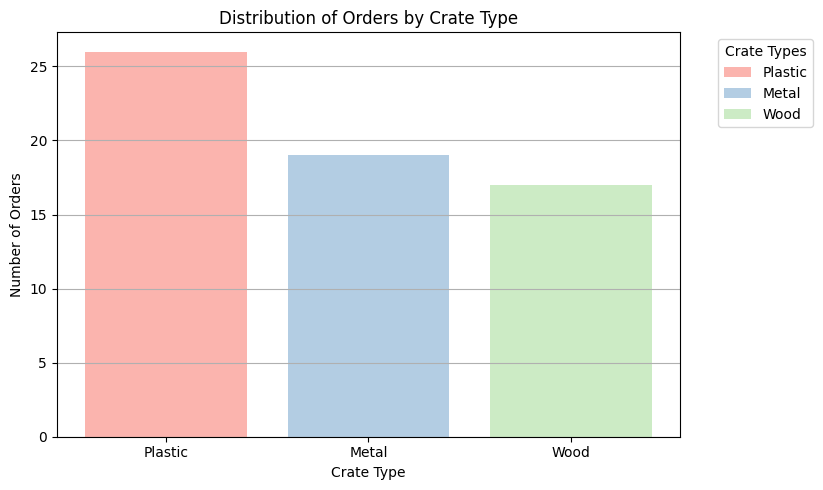

In [19]:
def plot_crate_type_distribution(df, savefig=False, start_date=None, end_date=None):
    """
    Plots the distribution of orders by crate type as a bar chart with each bar in a different color.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'crate_type' column.
    - savefig (bool): Whether to save the figure to a file. Defaults to False.
    - filename (str): The filename for saving the figure. Defaults to 'crate_type_distribution.png'.

    Returns:
    - None
    """
    if start_date and end_date:
        df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
    elif start_date:
        df = df[df['date'] >= pd.to_datetime(start_date)]
    elif end_date:
        df = df[df['date'] <= pd.to_datetime(end_date)]
        
    # Ensure the 'crate_type' column exists
    if 'crate_type' not in df.columns:
        raise ValueError("DataFrame must contain a 'crate_type' column.")

    crate_counts = df['crate_type'].value_counts()
    crate_types = crate_counts.index.tolist()
    counts = crate_counts.values
    num_crates = len(crate_types)
    
    cmap = plt.get_cmap('Pastel1')
    colors = [cmap(i) for i in range(num_crates)]

    plt.figure(figsize=(7, 5))
    bars = plt.bar(crate_types, counts, color=colors)
    plt.xlabel('Crate Type')
    plt.ylabel('Number of Orders')
    plt.title('Distribution of Orders by Crate Type')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.legend(bars, crate_types, title="Crate Types", bbox_to_anchor=(1.05, 1), loc='upper left')

    if savefig:
        plt.savefig('crate_type_distribution.png')

    plt.show()

plot_crate_type_distribution(staged_orders_df)

### 14. Understanding Sales Owner Success
Pareto charts are instrumental in identifying the most significant factors in a dataset. The `plot_pareto_chart` function generates Pareto charts for either the number of orders per sales owner or the commission amounts per sales owner. By displaying both the individual contributions and the cumulative percentage, these charts help prioritize efforts and identify key contributors. The function supports filtering by crate type and date range, allowing for targeted analyses. We do not show the plot for with commission amounts per sale owner because there are no invoices in the last year.

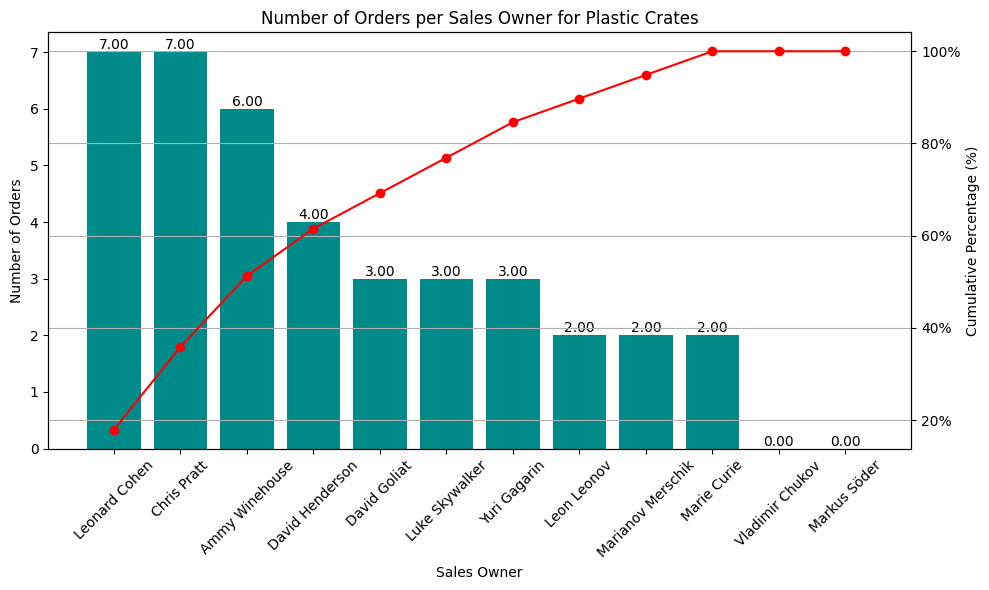

In [20]:
# Function to plot Pareto chart
def plot_pareto_chart(df, plot_type, crate_type='all', start_date=None, end_date=None, commission_rates=None, savefig=False):
    """
    Generate and display a Pareto chart for orders or commissions per sales owner.

    This function creates a Pareto chart to visualize either the distribution of the number of orders
    per sales owner or the commission amounts per sales owner, along with the cumulative percentage.
    It supports filtering by crate type and date range.

    Parameters:
    df (pd.DataFrame): The DataFrame containing sales data. It must include columns such as 'date', 'salesowners','crate_type', and 'net_invoice_value' (if plotting commissions).
    plot_type (str): The type of data to plot. Must be one of:
        - 'orders_per_salesowner': Plots the number of orders per sales owner.
        - 'commission_per_salesowner': Plots the commission amount per sales owner.
    crate_type (str, optional): The crate type to filter the data on (e.g., 'Plastic', 'Wood'). Use 'all' to include all crate types. Defaults to 'all'.
    start_date (datetime or str, optional): The start date for filtering the data. Only records on or after this date are included. Defaults to None.
    end_date (datetime or str, optional): The end date for filtering the data. Only records on or before this date are included.Defaults to None.
    commission_rates (list of float, optional): A list of commission rates corresponding to sales owner positions (e.g., [0.06, 0.025, 0.0095]). Required if plot_type is 'commission_per_salesowner'. Defaults to None.
    savefig (boolean): If True, the plotted graph will be saved as a .png. Defaults to False.
    
    Raises:
    ValueError: If an invalid plot_type is provided.

    Returns:
    None: The function displays the Pareto chart using Matplotlib and does not return any value.

    Notes:
    - The function calculates cumulative percentages to display the Pareto curve.
    - For 'commission_per_salesowner', it utilizes the 'calculate_commissions' function to compute commissions.

    Example Usage:
    ```
    # Plotting number of orders per sales owner for Plastic crates in the last year
    twelve_months_ago = datetime.now() - timedelta(days=365)
    plot_pareto_chart(sales_df, 'orders_per_salesowner', crate_type='Plastic', start_date=twelve_months_ago)

    # Plotting commission amounts per sales owner for all crates
    commission_rates = [0.06, 0.025, 0.0095]
    plot_pareto_chart(sales_df, 'commission_per_salesowner', commission_rates=commission_rates)
    ```
    """
    if start_date and end_date:
        df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
    elif start_date:
        df = df[df['date'] >= pd.to_datetime(start_date)]
    elif end_date:
        df = df[df['date'] <= pd.to_datetime(end_date)]
        
    if plot_type == 'orders_per_salesowner':
        if crate_type and crate_type != 'all':
            df = df[df['crate_type'] == crate_type]
        
        salesowner_orders = (df['salesowners']
                             .str.split(',')
                             .explode()
                             .str.strip()
                             .value_counts()
                             .reset_index())
        salesowner_orders.columns = ['Sales Owner', 'Number of Orders']
        
        all_salesowners = sales_df['salesowners'].str.split(',').explode().str.strip().unique()
        salesowner_orders = pd.DataFrame(all_salesowners, columns=['Sales Owner']).merge(salesowner_orders, on='Sales Owner', how='left').fillna(0)
        salesowner_orders['Number of Orders'] = salesowner_orders['Number of Orders'].astype(int)
        salesowner_orders = salesowner_orders.sort_values(by='Number of Orders', ascending=False)
        y_values = salesowner_orders['Number of Orders']
        title = f'Number of Orders per Sales Owner for {crate_type if crate_type != "all" else "All"} Crates'
        ylabel = 'Number of Orders'
    
    elif plot_type == 'commission_per_salesowner':
        commissions_df = calculate_commissions(df, 'salesowners', 'net_invoice_value', commission_rates, crate_type, start_date, end_date)
        y_values = commissions_df['Commission (€)']
        salesowner_orders = commissions_df
        title = f'Commission Amount per Sales Owner for {crate_type if crate_type != "all" else "All"} Crates'
        ylabel = 'Commission Amount (€)'
    else:
        raise ValueError("Invalid plot_type. Use 'orders_per_salesowner' or 'commission_per_salesowner'")
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(salesowner_orders['Sales Owner'], y_values, color='darkcyan', label='Value')
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    ax1.set_ylabel(ylabel)
    ax1.set_title(title)
    ax1.set_xlabel('Sales Owner')
    ax1.tick_params(axis='x', rotation=45)
    
    cumulative_percentage = y_values.cumsum() / y_values.sum() * 100
    ax2 = ax1.twinx()
    ax2.plot(salesowner_orders['Sales Owner'], cumulative_percentage, color='red', marker='o', label='Cumulative Percentage')
    ax2.set_ylabel('Cumulative Percentage (%)')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
    plt.grid()
    plt.tight_layout()
    if savefig==True:
        if plot_type == 'orders_per_salesowner': 
            plt.savefig(f'pareto_{crate_type}_num_orders.png')
        if plot_type == 'commission_per_salesowner':
            plt.savefig(f'pareto_{crate_type}_commission.png')
    plt.show()

twelve_months_ago = datetime.now() - timedelta(days=365)
plot_pareto_chart(sales_df, 'orders_per_salesowner', crate_type='Plastic', start_date=twelve_months_ago, end_date=None)

### 15. Visualize the Top 5 Performers
To understand the top 5 sales owners per month, a new dataframe has been constructed with the use of `calculate_commissions` function. For each month, we look back to the past three months and determine the top 5 sales owners. Then, these were plotted in a stacked bar chart for easy identification.

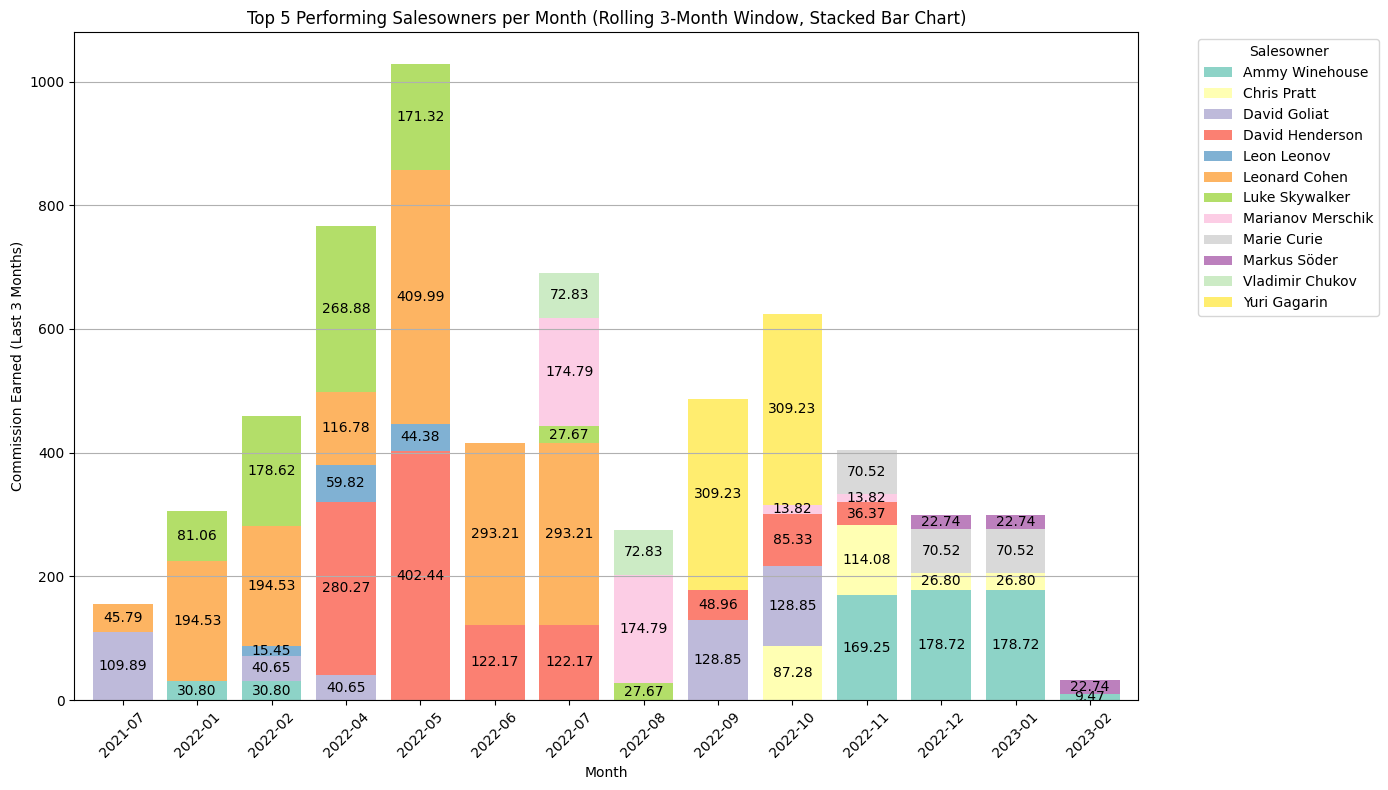

In [21]:
sales_df['year_month'] = sales_df['date'].dt.to_period('M')

top_performers_per_month = pd.DataFrame()

commission_rates = [0.06, 0.025, 0.0095]  # Example commission rates for sales owners
for period, group in sales_df.groupby('year_month'):
    # Get data for the current and previous two months
    end_date = group['date'].max()
    start_date = end_date - pd.DateOffset(months=2)
    data_window = sales_df[(sales_df['date'] > start_date) & (sales_df['date'] <= end_date)]
    
    commission_summary = calculate_commissions(data_window, 'salesowners', 'net_invoice_value', commission_rates)
    
    top_performers = commission_summary.nlargest(5, 'Commission (€)')
    top_performers['year_month'] = period
    top_performers_per_month = pd.concat([top_performers_per_month, top_performers], ignore_index=True)

top_performers_df = pd.DataFrame(top_performers_per_month)

def plot_top_performers_stacked(top_performers_df, savefig=False):
    """
    Plots the top 5 performing salesowners per month using a stacked bar chart.
    Filters out months with 0 commission.

    Parameters:
        top_performers_df (pd.DataFrame): Dataframe containing the salesowners, commission, and year_month columns.
    """
    filtered_df = top_performers_df[top_performers_df['Commission (€)'] > 0]
    pivot_df = filtered_df.pivot(index='year_month', columns='Sales Owner', values='Commission (€)').fillna(0)

    ax = pivot_df.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 8),
        colormap='Set3',
        width=0.8
    )
    plt.xlabel('Month')
    plt.ylabel('Commission Earned (Last 3 Months)')
    plt.title('Top 5 Performing Salesowners per Month (Rolling 3-Month Window, Stacked Bar Chart)')
    plt.xticks(rotation=45)
    plt.legend(title='Salesowner', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for container in ax.containers:
        labels = [f'{v:.2f}' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center')
        
    plt.tight_layout()
    plt.grid(axis='y')
    if savefig == True:
        plt.savefig(f'top_5_performers.png')
    plt.show()

plot_top_performers_stacked(top_performers_df, savefig=False)